<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex2_GIRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks through building a gradient impulse response function (GIRF) and applying the GIRF model to predict distortions in gradient waveforms.

This demo minimally adapts MATLAB code created by Johanna Vannesjo and Lars Kasper, two of the GIRF method authors (see https://github.com/MRI-gradient/GIRF for their implementation).

See this list of references:


In [12]:
# installing a python package for RF/gradient pulse design utilities
!pip install pulpy
!pip install numpy==1.25

In [13]:
!git clone https://github.com/jonbmartin/Gradient-Waveform-Errors-Demos
import sys
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos')
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos/utils/')
from waveforms import *

fatal: destination path 'Gradient-Waveform-Errors-Demos' already exists and is not an empty directory.


In [14]:
import numpy as np
import pulpy.grad as pulpgrad
import matplotlib.pyplot as plt
import pylab as pylab
from scipy.fftpack import fft, ifft, fftfreq, fftshift

Ok, next let us build some test waveforms to build/evaluate the GIRF. We will construct a simple chirp waveform and a standard blip gradient.

In [20]:
def chirp(t, f0, f1, T):
  # TODO: Slew rate limited chirp.
  """Generates a linear gradient chirp waveform.

  Args:
    t: Time vector.
    f0: Starting frequency.
    f1: Ending frequency.
    T: Duration of the chirp.

  Returns:|
    A numpy array representing the chirp waveform.
  """
  return np.sin(2 * np.pi * (f0 + (f1 - f0) / T * t) * t)

# Example usage
dt = 5e-6 # [s]
T = 0.5 # [s]
T_sweep = 0.05 # [s]
t = np.linspace(0, T_sweep, int(T_sweep/dt))
t_full = np.linspace(0, T, int(T/dt))

f0 = 0  # Starting frequency (Hz)
f1 = 300*10^3 # Ending frequency (Hz)
chirp_waveform = chirp(t, f0, f1, T_sweep)
# chirp_waveform_2 = chirp(t,f0,f1/10,T_sweep)

trap_waveform,_ = pulpgrad.trap_grad(area=1E-7, gmax=0.1, dgdt=20,dt=dt)
trap_waveform = trap_waveform/np.max(np.abs(trap_waveform))
print(np.shape(trap_waveform))


(1, 32)


In [25]:


# --- Define Chirp Parameters ---
N = 1020       # Number of points
dt = 0.01      # Timestep (ms) -> 10 ms total duration
G1 = 2        # Max gradient (G/cm)
f1 = 0.5       # Start frequency (kHz)
f2 = 5.0       # End frequency (kHz)
slr = 12      # Slew rate limit (G/cm/ms)

# --- Generate and Plot the Chirp ---
# We plot the slew rate to verify that we are indeed getting a slew-constrained
# chirp waveform.
chirp_waveform_slr, slr_time_vector = chirp_slew_constrained(N, dt, G1, f1, f2, slr)
chirp_waveform_slr = chirp_waveform_slr/np.max(np.abs(chirp_waveform_slr))
slr_time_vector = slr_time_vector/1000 # [s]
# chirp_waveform = chirp_waveform[:,None]

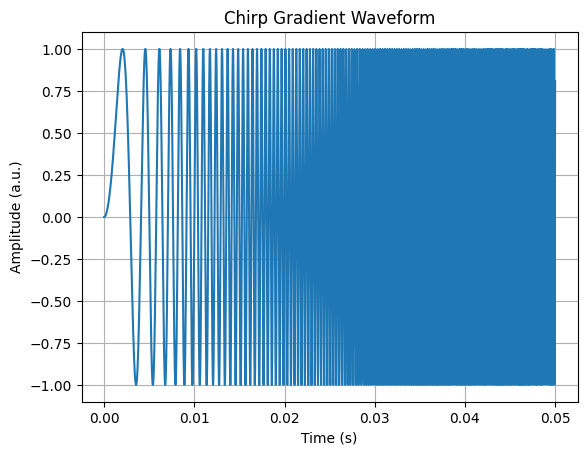

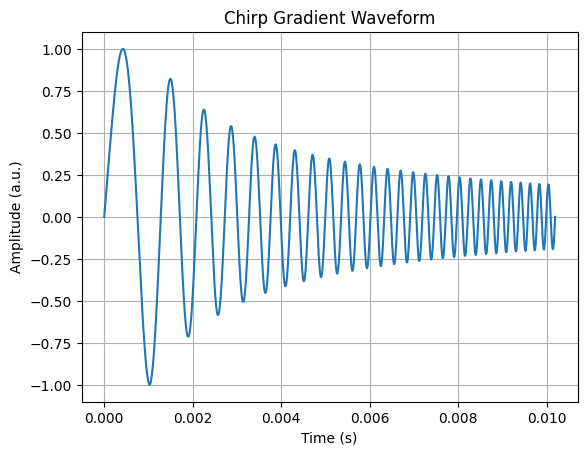

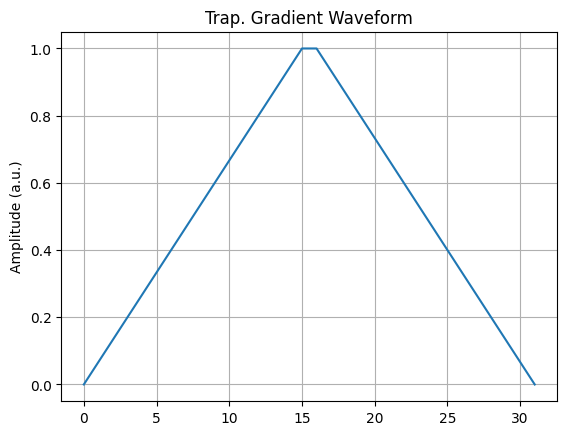

In [26]:
# Plot the chirp waveform
plt.plot(t, chirp_waveform)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Chirp Gradient Waveform')
plt.grid(True)
plt.show()

# Plot the chirp waveform
plt.plot(slr_time_vector, chirp_waveform_slr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Chirp Gradient Waveform')
plt.grid(True)
plt.show()

# Plot the blip waveform
plt.plot(np.squeeze(trap_waveform))
# plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Trap. Gradient Waveform')
plt.grid(True)
plt.show()

Ok, next we simulate a very simple gradient hardware system. Let's say that our hardware just low-pass filters our input - a fairly realistic, linear distortion.

In [47]:
chirp_waveform_padded = np.pad(chirp_waveform, (1000, len(t_full) - len(t)-1000))
small_chirp = np.roll(chirp_waveform_padded,50)
# chirp_waveform_2 = np.pad(chirp_waveform_2, (1000, len(t_full) - len(t)-1000))
trap_waveform_padded = np.pad(np.squeeze(trap_waveform), (1000, len(t_full) - len(np.squeeze(trap_waveform))-1000))
n_waveforms = 1

inTime = np.stack((chirp_waveform_padded, trap_waveform_padded, ), axis=1)
print(np.shape(inTime))

# JBM overwriting
inTime = chirp_waveform_slr[:,None]
# add a small amount of noise to the input waveforms:
inTime = inTime + np.random.normal(0, 0.01, np.shape(inTime))*5e-4

inFreq = np.zeros(np.shape(inTime), dtype=complex)
outTime = np.zeros(np.shape(inTime), dtype=complex)
outFreq = np.zeros(np.shape(inTime), dtype=complex)

thresh = 6E3 # [Hz]
for ii in range(n_waveforms):
  signal = inTime[:,ii]
  W = fftfreq(signal.size, d=slr_time_vector[1]-slr_time_vector[0])
  f_signal = fft(signal)
  inFreq[:,ii] = fftshift(f_signal)

  # If our original signal time was in seconds, this is now in Hz
  cut_f_signal = f_signal.copy()
  cut_f_signal[(abs(W)<thresh)] = cut_f_signal[(abs(W)<thresh)] * (1-abs(W[(abs(W)<thresh)])/thresh)
  cut_f_signal[(abs(W)>thresh)] = 0
  outFreq[:,ii] = cut_f_signal

  cut_signal = ifft(cut_f_signal)
  outTime[:,ii] = cut_signal

(99999, 2)


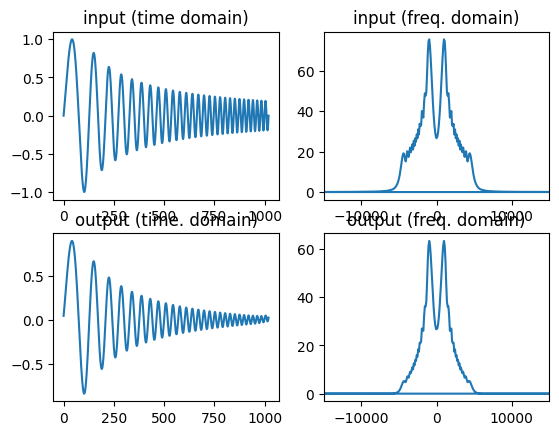

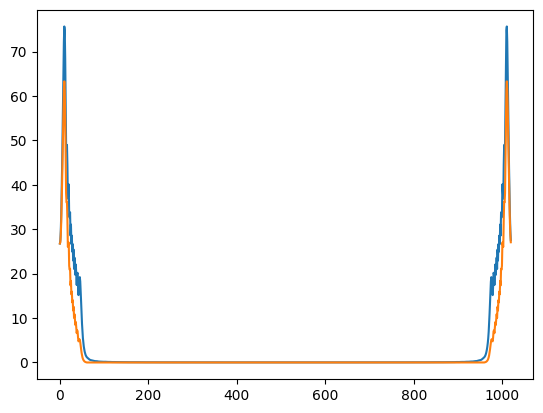

In [48]:
pylab.subplot(221)
pylab.plot(signal)
# pylab.xlim(0,12000)
pylab.title('input (time domain)')
pylab.subplot(222)
pylab.plot(W,np.abs(f_signal))

pylab.title('input (freq. domain)')
pylab.xlim(-1.5E4,1.5E4)
pylab.subplot(224)
pylab.plot(W,np.abs(cut_f_signal))
pylab.title('output (freq. domain)')
pylab.xlim(-1.5E4,1.5E4)
pylab.subplot(223)
pylab.plot(cut_signal)
# pylab.xlim(0,12000)
pylab.title('output (time. domain)')
pylab.show()

plt.plot(np.abs(f_signal))
plt.plot(np.abs(cut_f_signal))
plt.show()


Next, we compute the GIRF:


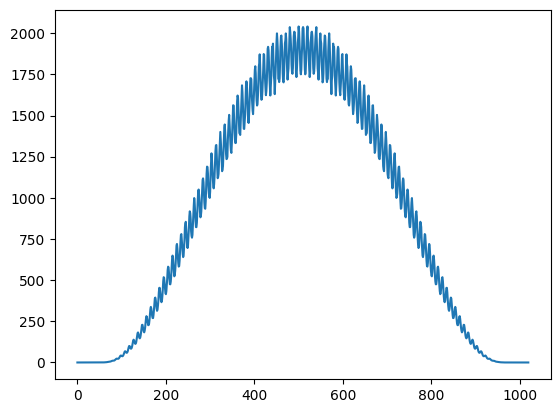

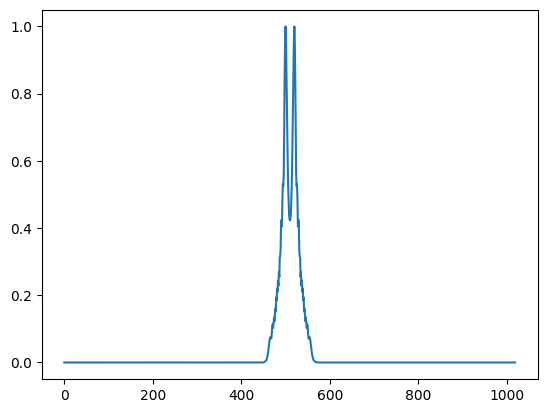

In [49]:
# FFTshift
# inFreq = np.fft.fftshift(inFreq, axes=0)
# outFreq = np.fft.fftshift(outFreq, axes=0)
inFreq = np.fft.fftshift(inFreq, axes=0)
outFreq = np.fft.fftshift(outFreq, axes=0)
# perform least-squares estimation from the input
inSOSInv = 1/(np.sum(np.abs(inFreq)**2,axis=1))

girf = np.sum(outFreq*np.conj(inFreq),axis=1)*inSOSInv
girf = girf / np.max(np.abs(girf))


plt.plot(inSOSInv)
plt.show()
plt.plot(np.abs(girf))
# plt.xlim([40000,60000])
plt.show()

Test the predictive power of our GIRF! We'll perform a frequency-domain application.

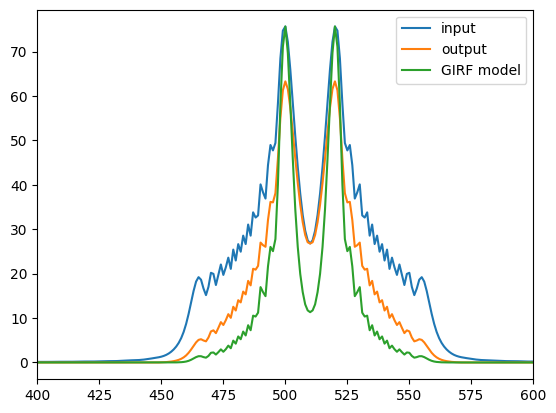

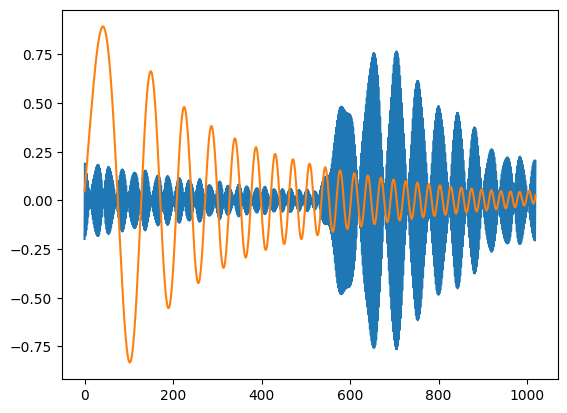

In [52]:
H = girf

out_pred = np.zeros(np.shape(inFreq), dtype=complex)
for ii in range(n_waveforms):
  out_pred[:,ii] = H * fftshift(inFreq[:,ii])

pylab.plot(np.abs(fftshift((inFreq[:,0]))))
pylab.plot(np.abs((outFreq[:,0])))
pylab.plot(np.abs((out_pred[:,0])))
pylab.xlim(400,600)
pylab.legend(['input', 'output', 'GIRF model'])

pylab.show()
#pylab.plot(-np.roll(ifft(fftshift(out[:,0])),10000))
waveform_index_plotting = 0
pylab.plot(fftshift(np.real(ifft(out_pred[:,waveform_index_plotting]))))
pylab.plot(outTime[:,waveform_index_plotting])
pylab.show()
